# Basic (binary) GP Classification model


This notebook shows how to build a GP classification model using variational inference. Here we consider binary (two-class, 0 vs 1) classification only (there is a separate notebook on [multi-class classification](../advanced/multiclass_classification.ipynb)). We first look at a one-dimensional example, and then show how this can be adapted when the input space is 2D.

In [1]:
import numpy as np
import gpflow

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (8, 4)

In [3]:
Y.dtype

NameError: name 'Y' is not defined

## 1D example

First of all, let's have a look at the data. We denote by X and Y the input and output values. Note that `X` and `Y` must be two-dimensional numpy arrays, $N \times 1$ or $N \times D$, where $D$ is the number of input dimensions/features, with the same number of rows $N$ (one per data-point):

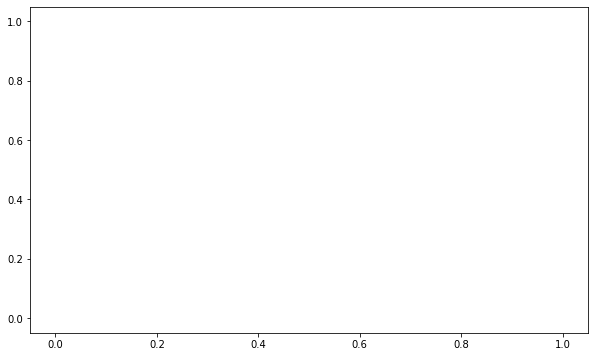

In [4]:
X = np.genfromtxt('data/classif_1D_X.csv').reshape(-1, 1)
Y = np.genfromtxt('data/classif_1D_Y.csv').reshape(-1, 1)

X = (X - X.mean()) / X.std()
Y = (Y - Y.mean()) / Y.std()

plt.figure(figsize=(10, 6))
plt.plot(X, Y, 'C3x', ms=8, mew=2);

### Reminders on the GP classification

For a binary classification model using GPs, we can simply use a `Bernoulli` likelihood. The details of the generative model are as follows:

__1. Define the latent GP:__ we start from a Gaussian process $f \sim \mathcal{GP}(0, k(., .))$:

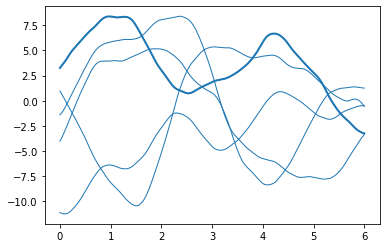

In [5]:
# build the kernel and covariance matrix
k = gpflow.kernels.Matern52(input_dim=1, variance=20.)
x_grid = np.linspace(0, 6, 200).reshape(-1, 1)
K = k.compute_K_symm(x_grid)

# sample from a multivariate normal
L = np.linalg.cholesky(K)
f_grid = np.dot(L, np.random.RandomState(6).randn(200, 5))
plt.plot(x_grid, f_grid, 'C0', linewidth=1)
plt.plot(x_grid, f_grid[:, 1], 'C0', linewidth=2);

__2. Squash them to $[0, 1]$:__ the samples of the GP are mapped to $[0, 1]$ using the logistic inverse link function: $g(x) = \frac{\exp(f(x))}{1 + \exp(f(x))}$.

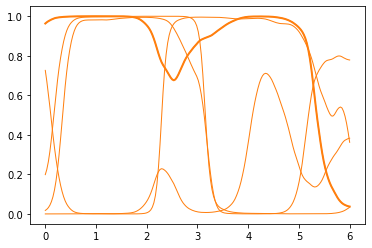

In [7]:
def logistic(f):
    return np.exp(f) / (1 + np.exp(f))
p_grid = logistic(f_grid)
plt.plot(x_grid, p_grid, 'C1', linewidth=1)
plt.plot(x_grid, p_grid[:, 1], 'C1', linewidth=2);

__3. Sample from a Bernoulli:__ for each observation point $X_i$, the class label $Y_i \in \{0, 1\}$ is generated by sampling from a Bernoulli distribution $Y_i \sim \mathcal{B}(g(X_i))$.

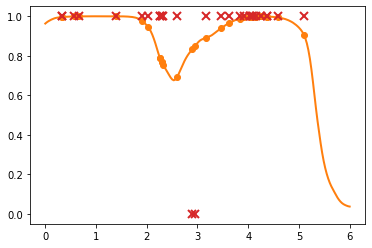

In [8]:
# Select some input locations
ind = np.random.randint(0, 200, (30,))
X_gen = x_grid[ind]

# evaluate probability and get Bernoulli draws
p = p_grid[ind, 1:2]
Y_gen = np.random.binomial(1, p)

# plot
plt.plot(x_grid, p_grid[:, 1], 'C1', linewidth=2)
plt.plot(X_gen, p, 'C1o', ms=6)
plt.plot(X_gen, Y_gen, 'C3x', ms=8, mew=2);

### Implementation with GPflow

For the model described above, the posterior $f(x)|Y$ (say $p$) is not Gaussian anymore and does not have a closed form expression. A common approach is then to look for the best approximation of this posterior by a tractable distribution (say $q$) such as a Gaussian distribution. In variational inference, the quality of an approximation is measured by the Kullback-Leibler divergence $\mathrm{KL}[q \| p]$. For more details on this model, see Nickisch and Rasmussen (2008).

The inference problem is thus turned into an optimisation problem: finding the best parameters for $q$. In our case, we introduce $U \sim \mathcal{N}(q_\mu, q_\Sigma)$ we choose $q$ to have the same distribution as $f | f(X) = U$. The parameters $q_\mu$ and $q_\Sigma$ can be seen as parameters of $q$, which can be optimised in order to minimise  $\mathrm{KL}[q \| p]$. 

This variational inference model is called `VGP` in GPflow:

In [9]:
m = gpflow.models.VGP(X, Y,
                      likelihood=gpflow.likelihoods.Bernoulli(),
                      kern=gpflow.kernels.Matern52(input_dim=1))

o = gpflow.train.ScipyOptimizer()
o.minimize(m);

InvalidArgumentError: Input matrix is not invertible.
	 [[node gradients/VGP-6c499804-9/Cholesky_grad/MatrixTriangularSolve (defined at /home/jovyan/.local/lib/python3.6/site-packages/gpflow/training/external_optimizer.py:463)  = MatrixTriangularSolve[T=DT_DOUBLE, adjoint=false, lower=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](VGP-6c499804-9/Cholesky, gradients/VGP-6c499804-9/Cholesky_grad/eye/MatrixDiag)]]

Caused by op 'gradients/VGP-6c499804-9/Cholesky_grad/MatrixTriangularSolve', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/opt/conda/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/opt/conda/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3215, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-072e5983dcab>", line 6, in <module>
    o.minimize(m);
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/training/scipy_optimizer.py", line 89, in minimize
    **kwargs)
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/training/external_optimizer.py", line 143, in minimize
    self._initialize_updated_shapes(session)
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/training/external_optimizer.py", line 221, in _initialize_updated_shapes
    loss_grads = _compute_gradients(self._loss, self._vars)
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/training/external_optimizer.py", line 463, in _compute_gradients
    grads = gradients.gradients(tensor, var_list)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 630, in gradients
    gate_gradients, aggregation_method, stop_gradients)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 814, in _GradientsHelper
    lambda: grad_fn(op, *out_grads))
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 408, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 814, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/linalg_grad.py", line 81, in _CholeskyGrad
    dtype=l.dtype))
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 1396, in matrix_triangular_solve
    adjoint=adjoint, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

...which was originally created as op 'VGP-6c499804-9/Cholesky', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 23 identical lines from previous traceback]
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-072e5983dcab>", line 3, in <module>
    kern=gpflow.kernels.Matern52(input_dim=1))
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/core/compilable.py", line 90, in __init__
    self.build()
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/models/model.py", line 79, in _build
    likelihood = self._build_likelihood()
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/decors.py", line 67, in tensor_mode_wrapper
    result = method(obj, *args, **kwargs)
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/models/vgp.py", line 108, in _build_likelihood
    L = tf.cholesky(K)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 709, in cholesky
    "Cholesky", input=input, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Input matrix is not invertible.
	 [[node gradients/VGP-6c499804-9/Cholesky_grad/MatrixTriangularSolve (defined at /home/jovyan/.local/lib/python3.6/site-packages/gpflow/training/external_optimizer.py:463)  = MatrixTriangularSolve[T=DT_DOUBLE, adjoint=false, lower=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](VGP-6c499804-9/Cholesky, gradients/VGP-6c499804-9/Cholesky_grad/eye/MatrixDiag)]]


We can now inspect the result of the optimisation with `print(m)` or `m.as_pandas_table()`:

In [9]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
VGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
VGP/q_mu,Parameter,None,(none),True,"(50, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 50, 50)",True,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In this table, the first two lines are associated with the kernel parameters, and the last two correspond to the variational parameters. Note that, in practice, $q_\Sigma$ is actually parametrised by its lower-triangular square root $q_\Sigma = q_\text{sqrt} q_\text{sqrt}^T$ in order to ensure its positive-definiteness.

For more details on how to handle models in GPflow (getting/setting parameters, fixing some of them during optimisation, using priors...), we refer the reader to the [notebook on models](../understanding/models.ipynb).

### Predictions

Finally, we will see how to use model predictions to plot the resulting model. We will replicate the figures of the generative model above, but using the approximate posterior distribution given by the model.

In [10]:
plt.figure(figsize=(12, 8))

# bubble fill the predictions
mu, var = m.predict_f(x_grid)
plt.fill_between(x_grid.flatten(),
                 (mu + 2 * np.sqrt(var)).flatten(),
                 (mu - 2 * np.sqrt(var)).flatten(),
                 alpha=0.3, color='C0')
    
# plot samples
samples = m.predict_f_samples(x_grid, 10).squeeze().T
plt.plot(x_grid, samples, 'C0', lw=1)
    
# plot p-samples
p = logistic(samples)  # exp(samples) / (1 + exp(samples))
plt.plot(x_grid, p, 'C1', lw=1)

# plot data
plt.plot(X, Y, 'C3x', ms=8, mew=2)
plt.ylim((-3,3))

InvalidArgumentError: Input matrix is not invertible.
	 [[node autoflow/VGP/predict_f/conditional/base_conditional/MatrixTriangularSolve (defined at /home/jovyan/.local/lib/python3.6/site-packages/gpflow/conditionals.py:218)  = MatrixTriangularSolve[T=DT_DOUBLE, adjoint=false, lower=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](autoflow/VGP/predict_f/conditional/base_conditional/Cholesky, autoflow/VGP/predict_f/conditional/mul_12)]]

Caused by op 'autoflow/VGP/predict_f/conditional/base_conditional/MatrixTriangularSolve', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/opt/conda/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/opt/conda/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-34b952bdab98>", line 4, in <module>
    mu, var = m.predict_f(x_grid)
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/decors.py", line 165, in autoflow_wrapper
    _build_method(method, obj, store)
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/decors.py", line 208, in _build_method
    store['result'] = method(obj, *store['arguments'])
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/models/model.py", line 158, in predict_f
    return self._build_predict(Xnew)
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/decors.py", line 67, in tensor_mode_wrapper
    result = method(obj, *args, **kwargs)
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/models/vgp.py", line 129, in _build_predict
    q_sqrt=self.q_sqrt, full_cov=full_cov, white=True)
  File "/home/jovyan/.local/lib/python3.6/site-packages/multipledispatch/dispatcher.py", line 278, in __call__
    return func(*args, **kwargs)
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/decors.py", line 49, in name_scope_wrapper
    return method(*args, **kwargs)
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/conditionals.py", line 122, in _conditional
    mean, var = base_conditional(Kmn, Kmm, Knn, f, full_cov=full_cov, q_sqrt=q_sqrt, white=white)
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/decors.py", line 49, in name_scope_wrapper
    return method(*args, **kwargs)
  File "/home/jovyan/.local/lib/python3.6/site-packages/gpflow/conditionals.py", line 218, in base_conditional
    A = tf.matrix_triangular_solve(Lm, Kmn, lower=True)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 1396, in matrix_triangular_solve
    adjoint=adjoint, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Input matrix is not invertible.
	 [[node autoflow/VGP/predict_f/conditional/base_conditional/MatrixTriangularSolve (defined at /home/jovyan/.local/lib/python3.6/site-packages/gpflow/conditionals.py:218)  = MatrixTriangularSolve[T=DT_DOUBLE, adjoint=false, lower=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](autoflow/VGP/predict_f/conditional/base_conditional/Cholesky, autoflow/VGP/predict_f/conditional/mul_12)]]


<Figure size 864x576 with 0 Axes>

## 2D example

In this section we will use the following data:

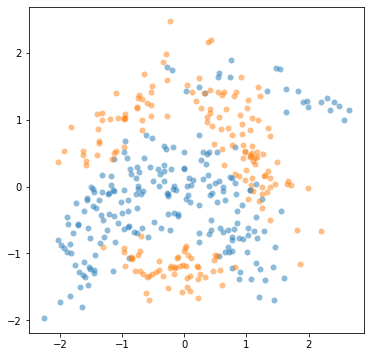

In [2]:
X = np.loadtxt('data/banana_X_train', delimiter=',')
Y = np.loadtxt('data/banana_Y_train', delimiter=',').reshape(-1,1)
mask = Y[:, 0]==1

plt.figure(figsize=(6, 6))
plt.plot(X[mask, 0], X[mask, 1], 'oC0', mew=0, alpha=0.5)
plt.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], 'oC1', mew=0, alpha=0.5);


The model definition is the same as above, the only important difference is that we now specify that the kernel operates over a 2D input space:

In [3]:
from datetime import datetime
m = gpflow.models.VGP(X, Y,
                      kern=gpflow.kernels.RBF(input_dim=2),
                      likelihood=gpflow.likelihoods.Bernoulli())
startTime = datetime.now()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, maxiter=2500) # in practice, the optimisation needs around 250 iterations to converge
print(datetime.now()-startTime)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.660963
  Number of iterations: 224
  Number of functions evaluations: 232


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.660963
  Number of iterations: 224
  Number of functions evaluations: 232


0:00:18.909102


We can now plot the predicted decision boundary between the two classes. To do so, we can equivalently plot the contour lines $E[f(x)|Y]=0$, or $E[g(f(x))|Y]=0.5$. We will do the latter since it allows us to introduce the function `predict_y`, which returns the mean and variance at test points:

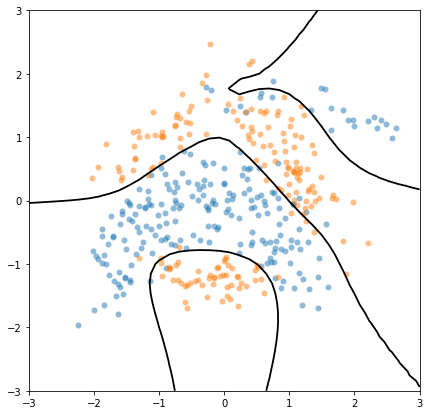

In [28]:
x_grid = np.linspace(-3, 3, 40)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(),yy.flatten())).T

p, _ = m.predict_y(Xplot)  # here we only care about the mean
plt.figure(figsize=(7, 7))
plt.plot(X[mask, 0], X[mask, 1], 'oC0', mew=0, alpha=0.5)
plt.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], 'oC1', mew=0, alpha=0.5);

plt.contour(xx, yy, p.reshape(*xx.shape), [0.5],  # plot the p=0.5 contour line only
            colors='k', linewidths=1.8, zorder=100);

In [35]:
import tensorflow as tf 
tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Further reading

There are dedicated notebooks giving more details on how to manipulate [models](../understanding/models.ipynb) and [kernels](../advanced/kernels.ipynb).

This notebook only covers very basic classification models. You may also be interested in:
  * [Multi-class classification](../advanced/multiclass_classification.ipynb) if you have more than two classes.
  * [Sparse models](../advanced/gps_for_big_data.ipynb). The models above have one inducing variable $U_i$ per observation point $X_i$, which does not scale to large datasets. SVGP (Sparse Variational GP) is an efficient alternative where the variables $U_i$ are defined at some inducing input locations $Z_i$ that can also be optimized.
  * [Exact inference](../advanced/mcmc.ipynb). We have seen that variational inference provides an approximation to the posterior. GPflow also supports exact inference using MCMC methods, and the kernel parameters can also be assigned prior distributions in order to avoid point estimates.
  
# References

Hannes Nickisch and Carl Edward Rasmussen. "Approximations for binary Gaussian process classification." Journal of Machine Learning Research 9(Oct):2035--2078, 2008.